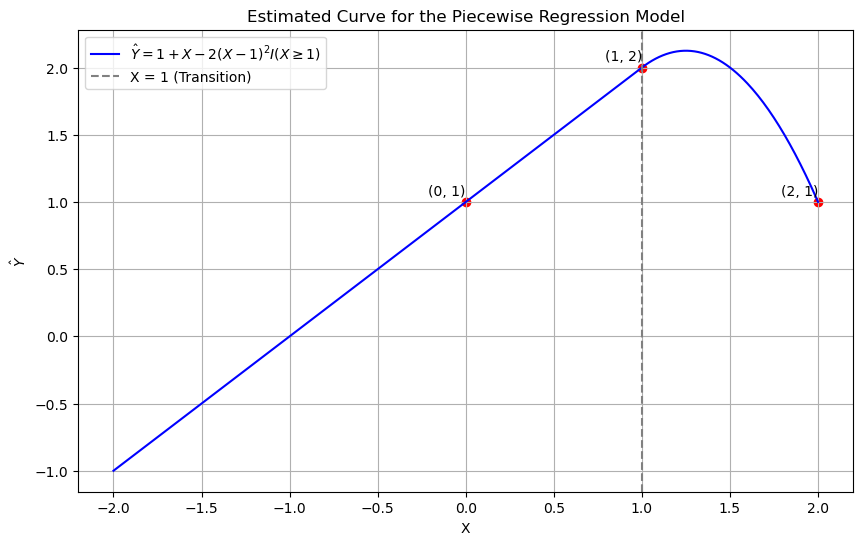

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the X range from -2 to 2
X = np.linspace(-2, 2, 400)

# Define the function based on the given piecewise regression model
def model(X):
    # For X < 1: Y = 1 + X
    Y = np.where(X < 1, 1 + X, 1 + X - 2 * (X - 1)**2)
    return Y

# Calculate Y values
Y = model(X)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(X, Y, label=r'$\hat{Y} = 1 + X - 2(X - 1)^2 I(X \geq 1)$', color='blue')
plt.axvline(x=1, linestyle='--', color='grey', label='X = 1 (Transition)')
plt.scatter([0, 1, 2], [1, 2, 1], color='red', marker='o')  # Marking intercepts and key points

# Annotations
plt.text(0, 1.05, '(0, 1)', horizontalalignment='right')
plt.text(1, 2.05, '(1, 2)', horizontalalignment='right')
plt.text(2, 1.05, '(2, 1)', horizontalalignment='right')

# Add labels and title
plt.xlabel('X')
plt.ylabel(r'$\hat{Y}$')
plt.title('Estimated Curve for the Piecewise Regression Model')
plt.legend()
plt.grid(True)
plt.show()


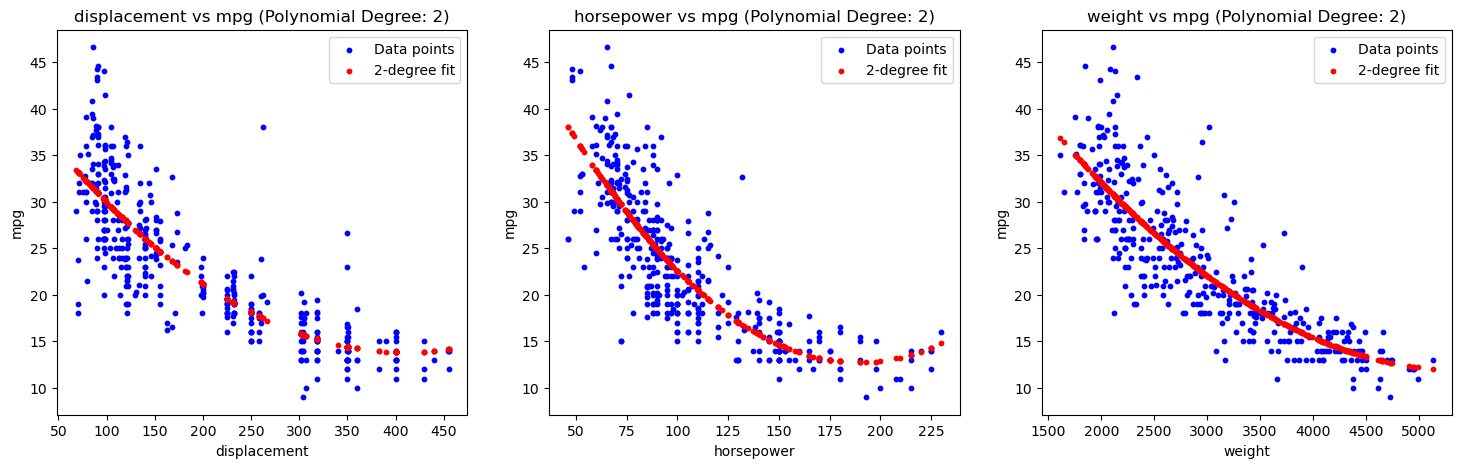

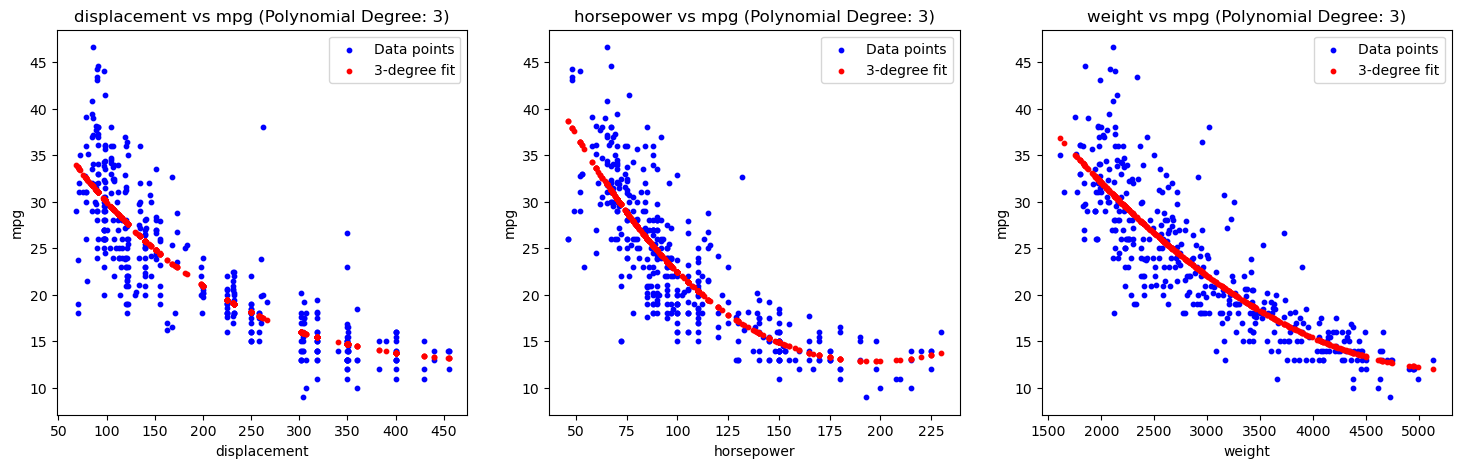

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset
auto_data = pd.read_csv('C:/Users/arman/Downloads/ALL+CSV+FILES+-+2nd+Edition+-+corrected/ALL CSV FILES - 2nd Edition/Auto.csv')

# Prepare data by converting horsepower to numeric (handle non-numeric values)
auto_data['horsepower'] = pd.to_numeric(auto_data['horsepower'], errors='coerce')
auto_data = auto_data.dropna()  # Drop rows with missing values

# Define predictor variables and target variable
predictors = ['displacement', 'horsepower', 'weight']
target = 'mpg'

# Function to fit and plot polynomial regression
def plot_polynomial_regression(degree):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, predictor in enumerate(predictors):
        X = auto_data[[predictor]]
        y = auto_data[target]
        
        # Polynomial transformation
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        
        # Fit model
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
        
        # Plot results
        axes[i].scatter(X, y, color='blue', s=10, label='Data points')
        axes[i].scatter(X, y_pred, color='red', s=10, label=f'{degree}-degree fit')
        axes[i].set_xlabel(predictor)
        axes[i].set_ylabel(target)
        axes[i].legend()
        axes[i].set_title(f'{predictor} vs {target} (Polynomial Degree: {degree})')

    plt.show()

# Plot polynomial regression with degree 2 and 3 to check for non-linear patterns
plot_polynomial_regression(degree=2)
plot_polynomial_regression(degree=3)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

# Load the dataset
data = pd.read_csv(r'C:/Users/arman/Downloads/playground-series-s4e4/train.csv')
test_data = pd.read_csv(r'C:/Users/arman/Downloads/playground-series-s4e4/test.csv')

# Splitting features and target variable
X = data.drop(columns=['Rings'])  # 'id' is still in X
y = data['Rings']

# Identify categorical columns 
categorical_cols = ['Sex']  

# Preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in X.columns if col not in categorical_cols and col != 'id']),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Split the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor with training data (exclude 'id' from fitting)
X_train_preprocessed = preprocessor.fit_transform(X_train.drop(columns=['id'])) 
X_val_preprocessed = preprocessor.transform(X_val.drop(columns=['id']))

# --- Polynomial Regression ---

# Create a pipeline with scaling and polynomial features
poly_pipeline = Pipeline(steps=[
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define parameter grid for GridSearchCV
param_grid_poly = {
    'poly__degree': [2, 3, 4],  # Try different polynomial degrees
}

# Create GridSearchCV object
grid_poly = GridSearchCV(poly_pipeline, param_grid_poly, cv=5, scoring='neg_mean_squared_error')
grid_poly.fit(X_train_preprocessed, y_train)

# Get the best model and predictions
best_poly_model = grid_poly.best_estimator_
y_pred_poly = best_poly_model.predict(X_val_preprocessed)

# Clip predictions to be non-negative
y_pred_poly = np.clip(y_pred_poly, 0, None)

# Evaluate the model
rmsle_poly = np.sqrt(mean_squared_log_error(y_val, y_pred_poly))
mse_poly = mean_squared_error(y_val, y_pred_poly)
r2_poly = r2_score(y_val, y_pred_poly)

print(f'Polynomial Regression RMSLE: {rmsle_poly}')
print(f'Polynomial Regression MSE: {mse_poly}')
print(f'Polynomial Regression R-squared: {r2_poly}')

# --- K-Nearest Neighbors ---

# Create a pipeline with scaling
knn_pipeline = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])

# Define parameter grid for GridSearchCV
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9]  # Try different values for k
}

# Create GridSearchCV object
grid_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_knn.fit(X_train_preprocessed, y_train)

# Get the best model and predictions
best_knn_model = grid_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_val_preprocessed)

# Evaluate the model
rmsle_knn = np.sqrt(mean_squared_log_error(y_val, y_pred_knn))
mse_knn = mean_squared_error(y_val, y_pred_knn)
r2_knn = r2_score(y_val, y_pred_knn)

print(f'KNN Regression RMSLE: {rmsle_knn}')
print(f'KNN Regression MSE: {mse_knn}')
print(f'KNN Regression R-squared: {r2_knn}')

# --- Predictions on test data ---

# Preprocess the test data (exclude 'id' from transformation)
X_test_preprocessed = preprocessor.transform(test_data.drop(columns=['id'])) 

# Polynomial model predictions
test_pred_poly = best_poly_model.predict(X_test_preprocessed)
test_pred_poly = np.clip(test_pred_poly, 0, None)  # Clip predictions

# KNN model predictions
test_pred_knn = best_knn_model.predict(X_test_preprocessed)

# --- Preparing submission files ---

submission_poly = pd.DataFrame({
    'id': test_data['id'],
    'Rings': np.round(test_pred_poly).astype(int)
})
submission_poly.to_csv('C:/Users/arman/Downloads/submission_poly.csv', index=False)

submission_knn = pd.DataFrame({
    'id': test_data['id'],
    'Rings': np.round(test_pred_knn).astype(int)
})
submission_knn.to_csv('C:/Users/arman/Downloads/submission_knn.csv', index=False)

Polynomial Regression RMSLE: 0.158222495302494
Polynomial Regression MSE: 3.7730747813926038
Polynomial Regression R-squared: 0.632696258214381
KNN Regression RMSLE: 0.1609529664675503
KNN Regression MSE: 3.916506751191957
KNN Regression R-squared: 0.6187333493797091
